# Logistic regression with SGD optimizer

## Steps:
<ol>
 <li>Load data</li>
 <li>Build Vocab (no need for preprocess since dataset seemed to be already processed)</li>
 <li>Convert to bag of words</li>
 <li>Train the model</li>
</ol>

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import re
import matplotlib.pyplot as plt

In [2]:
# Load training and testing data
x_train = np.load('imdb_data/x-train.npy', allow_pickle=True) 
y_train = np.load('imdb_data/y-train.npy', allow_pickle=True)  

x_test = np.load('imdb_data/x-test.npy', allow_pickle=True)   
y_test = np.load('imdb_data/y-test.npy', allow_pickle=True)

In [3]:
print(x_train[0])
print(y_train[0])
print(type(x_train))
print(len(x_train))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
1
<class 'numpy.ndarray'>
25000


In [4]:
#Build vocabulary based 
def build_vocab(sequences, vocab_size):
    counter = Counter()
    for seq in sequences:
        counter.update(seq)
        
    most_common = counter.most_common(vocab_size)
    vocab = {token: idx for idx, (token, _) in enumerate(most_common)}
    return vocab

In [5]:
#convert to BoW 
def token_to_Bow(sequences, vocab):
    bow = np.zeros(len(vocab))
    token_counts = Counter(sequences)
    for token, count in token_counts.items():
        if token in vocab:
            bow[vocab[token]] = count
    return bow

In [6]:
vocab = build_vocab(x_train, vocab_size=10_000)

In [7]:
print(len(vocab))

9998


In [8]:
X_train = np.array([token_to_Bow(sequences, vocab) for sequences in x_train])
X_test = np.array([token_to_Bow(sequences, vocab) for sequences in x_test])

In [9]:
print(f'X_train: {X_train}')
print(f'X_test: {X_test}')

X_train: [[ 6. 15.  9. ...  0.  0.  0.]
 [ 7. 15. 10. ...  0.  0.  0.]
 [ 2.  9.  0. ...  0.  0.  0.]
 ...
 [14. 13.  5. ...  0.  0.  0.]
 [ 5.  5.  7. ...  0.  0.  0.]
 [12. 10.  6. ...  0.  0.  0.]]
X_test: [[ 3.  3.  2. ...  0.  0.  0.]
 [ 7. 18.  9. ...  0.  0.  0.]
 [68. 36. 11. ...  0.  0.  0.]
 ...
 [ 2.  3.  1. ...  0.  0.  0.]
 [ 1.  8.  4. ...  0.  0.  0.]
 [10.  8.  3. ...  0.  0.  0.]]


In [10]:
X_train.shape

(25000, 9998)

In [13]:
class LogisticRegressionSGD:
    def __init__(self, learning_rate=0.01, epochs=10):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = 0
        self.loss_history = []
    
    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def train(self, X, y):
        num_samples, num_features = X.shape
        self.weights = np.zeros(num_features)
        
        print('Training starts here:')
        for epoch in range(self.epochs):
            epoch_loss = 0  
            for i in range(num_samples):
                xi = X[i]
                yi = y[i]
                linear_output = np.dot(xi, self.weights) + self.bias
                prediction = self.sigmoid(linear_output)

                # Compute gradients
                error = prediction - yi
                self.weights -= self.learning_rate * error * xi
                self.bias -= self.learning_rate * error  # Update bias

                # Calculate loss for this sample and add to epoch_loss
                epsilon = 1e-10
                sample_loss = - (yi * np.log(prediction + epsilon) + (1 - yi) * np.log(1 - prediction + epsilon))
                epoch_loss += sample_loss

            # Average loss over the samples in the epoch
            epoch_loss /= num_samples
            self.loss_history.append(epoch_loss)
            if epoch == 0 or (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}, Loss: {epoch_loss:.4f}')

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return (self.sigmoid(linear_output) >= 0.5).astype(int)

In [12]:
# Train model
model = LogisticRegressionSGD(learning_rate=0.01, epochs=50)
model.train(X_train, y_train)

Training starts here:
Epoch 1, Loss: 1.4756
Epoch 11, Loss: 0.4615
Epoch 21, Loss: 0.2901
Epoch 31, Loss: 0.2093
Epoch 41, Loss: 0.1507


In [37]:
y_pred = model.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f'Accuracy Epoch=50: {accuracy:.4f}')
#print(f'Accuracy Epoch=100: {accuracy:.4f}')

Accuracy Epoch=50: 0.8479


In [14]:
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1]
epochs = 50
results = {}

for lr in learning_rates:
    print(f"Training with learning_rate={lr}")
    model = LogisticRegressionSGD(learning_rate=lr, epochs=epochs)
    model.train(X_train, y_train)
    
    # Assuming model.predict exists and returns binary predictions (0 or 1)
    predictions = model.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    results[lr] = accuracy
    print(f"Accuracy for learning_rate {lr}: {accuracy:.4f}\n{'='*50}\n")

# Print a summary of accuracies:
print("Learning Rate Results:")
for lr, acc in results.items():
    print(f"Learning Rate: {lr:.3f} -> Accuracy: {acc:.4f}")

Training with learning_rate=0.001
Training starts here:
Epoch 1, Loss: 0.5069
Epoch 10, Loss: 0.2571
Epoch 20, Loss: 0.2134
Epoch 30, Loss: 0.1894
Epoch 40, Loss: 0.1733
Epoch 50, Loss: 0.1613
Accuracy for learning_rate 0.001: 0.8778

Training with learning_rate=0.005
Training starts here:
Epoch 1, Loss: 0.8781
Epoch 10, Loss: 0.2756
Epoch 20, Loss: 0.1819
Epoch 30, Loss: 0.1412
Epoch 40, Loss: 0.1148
Epoch 50, Loss: 0.0984
Accuracy for learning_rate 0.005: 0.8563

Training with learning_rate=0.01
Training starts here:
Epoch 1, Loss: 1.4756
Epoch 10, Loss: 0.5101
Epoch 20, Loss: 0.2984
Epoch 30, Loss: 0.2227
Epoch 40, Loss: 0.1666
Epoch 50, Loss: 0.1271
Accuracy for learning_rate 0.01: 0.8479

Training with learning_rate=0.05
Training starts here:
Epoch 1, Loss: 4.0023


/tmp/ipykernel_59499/787733444.py:10: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


Epoch 10, Loss: 1.6428
Epoch 20, Loss: 1.1506
Epoch 30, Loss: 0.9312
Epoch 40, Loss: 0.8163
Epoch 50, Loss: 0.7199
Accuracy for learning_rate 0.05: 0.8404

Training with learning_rate=0.1
Training starts here:
Epoch 1, Loss: 4.8308
Epoch 10, Loss: 2.1412
Epoch 20, Loss: 1.5860
Epoch 30, Loss: 1.3802
Epoch 40, Loss: 1.1425
Epoch 50, Loss: 0.9563
Accuracy for learning_rate 0.1: 0.8502

Learning Rate Results:
Learning Rate: 0.001 -> Accuracy: 0.8778
Learning Rate: 0.005 -> Accuracy: 0.8563
Learning Rate: 0.010 -> Accuracy: 0.8479
Learning Rate: 0.050 -> Accuracy: 0.8404
Learning Rate: 0.100 -> Accuracy: 0.8502


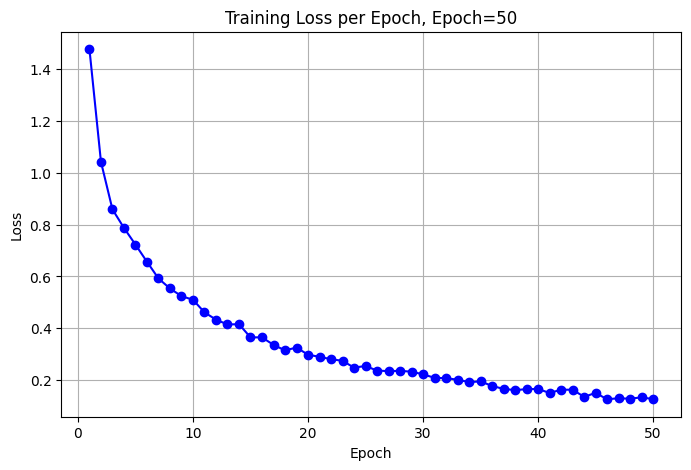

In [38]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, model.epochs + 1), model.loss_history, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch, Epoch=50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

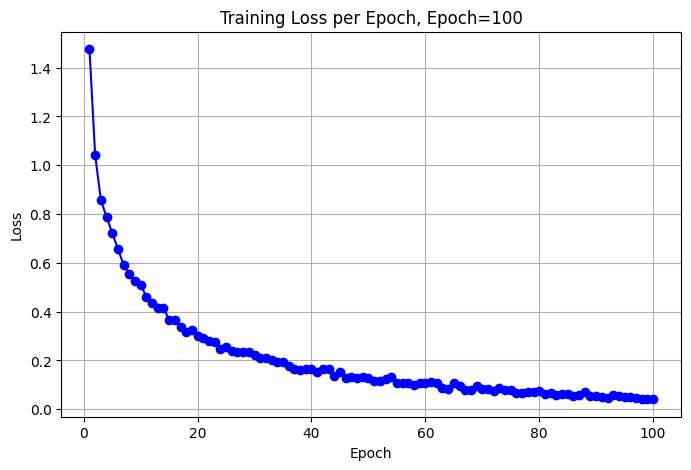

In [20]:
# Plot training loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(range(1, model.epochs + 1), model.loss_history, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch, Epoch=100')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [18]:
print("Snippet of the Bag-of-Words matrix (first 5 samples, first 10 features):")
print(X_train[:5, :10])

Snippet of the Bag-of-Words matrix (first 5 samples, first 10 features):
[[ 6. 15.  9.  3.  2.  3.  1.  0.  0.  6.]
 [ 7. 15. 10.  3.  2.  3. 10.  0.  2.  0.]
 [ 2.  9.  0.  4.  4.  4.  2.  0.  2.  4.]
 [51. 36. 12.  8. 21. 12. 12. 16. 12.  8.]
 [ 1.  2.  6.  2.  4.  2.  0.  2.  2.  3.]]


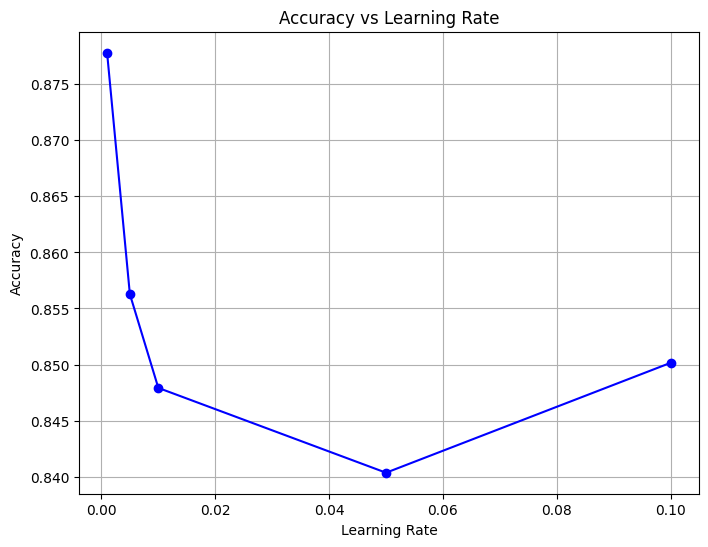

In [15]:
sorted_lrs = sorted(results.keys())
sorted_acc = [results[lr] for lr in sorted_lrs]

plt.figure(figsize=(8, 6))
plt.plot(sorted_lrs, sorted_acc, marker='o', linestyle='-', color='b')
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Learning Rate")
plt.grid(True)
plt.show()